# 决策树原理

决策树是一个分而治之的递归过程。
- 构建根节点，将所有训练数据都放在根节点。
- 选择一个最优特征，按照这一特征将训练数据集分割成子集，使得各个子集有一个在当前条件下最好的分类。
- 如果子集未分类完毕，则在子集中选择一个最优特征，继续进行划分，直到所有训练数据子集都被正确分类或没有合适的特征为止。
                    
         

## 决策树三要素：

- 特征选择：从训练数据中众多的特征中选择一个特征作为当前节点的分裂标准，如何选择特征有着很多不同量化评估标准标准，从而衍生出不同的决策树算法。
- **决策树生成：**根据选择的特征评估标准，从上至下递归地生成子节点，直到数据集不可分则停止决策树停止生长。
- **决策树的修剪：**决策树容易过拟合，一般来需要剪枝，缩小树结构规模、缓解过拟合。剪枝技术有预剪枝和后剪枝两种。



## 特征选择方法
有三种方法进行特征选择：`ID3`: 信息增益，`C4.5`: 信息增益比，`CART`: 基尼系数


### `ID3`
   - 信息熵(`information entropy`)
$$\operatorname{Ent}(D)=-\sum_{k=1}^{|\mathcal{Y}|}p_k\log_{2}{p_k}$$
其中，$|\mathcal{Y}|$ 表示样本类别总数，$p_k$ 表示第 $k$ 类样本所占的比例
    - **信息增益(`information gain`)**
    $$\operatorname{Gain}(D,a) = \operatorname{Ent}(D) - \sum_{v=1}^{V}\frac{|D^v|}{|D|}\operatorname{Ent}({D^v})$$
    其中，属性 $a$ 有 $V$ 个取值，取值 $a^v$ 的样本数量 $D^v$
    - 一般来说，信息增益越大，意味着使用属性 $a$ 划分所获得纯度提升越大
    

In [ ]:
####### 信息熵的实现
def entropy(y):
    hist = np.bincount(y)
    ps = hist / np.sum(hist)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

####### 信息增益
def gain(y, subsets):
    """
    y 根据某一指标划分后的子集
    """
    return entropy(y) - sum([len(sub_y) * entropy(sub_y)
                             for sub_y in subsets]) / len(y)

In [18]:
y = [0, 0, 0, 1, 1]
entropy(y)

0.9709505944546686

    
### `C4.5`
   - 信息增益准则对可取值数目较多的属性有所偏好，**增益率(`gain ratio`)**:
    $$\operatorname{Gain\_ratio}(D,a) = \frac{\operatorname{Gain}(D,a)}{\operatorname{IV}(a)}$$
    其中，$$\operatorname{IV}(a) = -\sum_{v=1}^{V}\frac{|D^v|}{|D|}\log_{2}{\frac{|D^v|}{|D|}}$$ 
    称为属性 $a$ 的固有值；属性 $a$ 的可能取值越多，该值越大。
    - 信息增益率对可能取值少的属性有所偏好；因此 C4.5 先从候选划分属性中找出信息增益高于平均水平的属性，再从中选择信息增益率最高的。
    
    

In [ ]:
####### 增益率
def gain_ratio(y, subsets):
    n = len(y)
    iv = -sum([(len(subset) / n) * np.log2(len(subset) / n)
               for subset in subsets])
    return gain(y, subsets) / iv

### `CART`
   - 数据集 $D$ 的纯度可用基尼值来度量：
$$\begin{aligned}\operatorname{Gini}(p) &=\sum_{k=1}^{|y|}\sum_{{k'}\neq k}{p_k}{p_{k'}}\ &=1-\sum_{k=1}^{|y|}p_k^2 \end{aligned}$$
    $Gini(D)$ 反应了从数据集 $D$ 中随机抽取两个样本，其类别标记不一致的概率。$Gini(D)$ 越小，则 $D$ 的纯度越高
    - 基尼指数(`Gini index`)
    $$\operatorname{Gini\_index}(D,a) = \sum_{v=1}^{V}\frac{|D^v|}{|D|}\operatorname{Gini}(D^v)$$
    选择使得划分后基尼指数最小的属性作为最优划分属性
    - 找出最优树是一个`NP-complete`问题，需要$O(e^m)$时间复杂度；贪心算法，获得近似最优解
    

In [5]:
##### 基尼值
def gini(y):
    hist = np.bincount(y)
    N = np.sum(hist)
    return 1 - sum([(i / N) for i in hist])

# 基尼指数
def gini_index(y, subsets):
    return np.sum([(len(subset) / len(y)) * gini(subset)
                   for subset in subsets])

## 决策树优缺点
- 决策树对数据基本没有假设(例如：线性模型假设数据是线性的)，泛化能力强，更容易过拟合
- 非参数化模型，参数数量在训练之前是未知的


计算复杂度：
* 做预测时，需要从根节点到叶节点横穿整根树，最大大概共$O(log_2(m))$个节点，每个节点只检查一个特征，计算复杂度即为$O(log_2(m))$
* 训练时，需要在所有节点上比较所有特征，计算复杂度$O(n*mlog(m))$,极大降低速度

    
黑箱模型：随机森林、神经网络等模型，很难清晰解释预测是怎么作出的

In [2]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive

data = load_wine()
X = data.data
y = data.target

labels = data.feature_names

print(labels)

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [5]:
print(X.shape, y.shape, len(set(y)))
# 178 样本，13个特征，3分类

(178, 13) (178,) 3


In [6]:
def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = DecisionTreeClassifier(
        random_state=0,
        criterion=crit,                # 指定特征选择方法，'gini'或'entropy'
        splitter=split,                # 特征划分策略，'best'或'random'
        max_depth=depth,               # 最大深度
        min_samples_split=min_split,   
        min_samples_leaf=min_leaf,
    )
    estimator.fit(X, y)
    graph = Source(
        tree.export_graphviz(estimator,
                             out_file=None,
                             feature_names=labels,
                             class_names=['0', '1', '2'],
                             filled=True))
    display(SVG(graph.pipe(format='svg')))
    return estimator


inter = interactive(plot_tree,
                    crit=['gini', 'entropy'],
                    split=['best', 'random'],
                    depth=[1, 2, 3, 4],
                    min_split=(0.1, 1),
                    min_leaf=(0.1, 0.5))
display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

> `sklearn.tree.DecisionTreeClassifier`，限制决策树的最大深度 `max_depth`，增大参数列表中 `min_*` 参数，减小 `max_*` 参数都将正则化模型

# 回归
- `CART` 算法试图拆分训练数据，以最小化 `MSE`
$$J(k,t_k)=\frac{m_{left}}{m}MSE_{left}+\frac{m_{right}}{m}MSE_{right}$$
- 缺点：倾向于正交边界，对训练数据的微小变动很敏感——使用`PCA`改善



## 最小二乘法回归树生成算法    
输入：训练数据集 D    
输出：回归树 f(x)

在训练数据集所在的输入空间中，递归的将每个区域划分为两个子域并决定每个子域上的输出值，构建二叉决策树


1. 选择最优切分变量 j 与切分点 s
$$ 
\mathop{min}\limits_{j,s}\Big[\mathop{min}\limits_{c_1}\sum\limits_{x_i\in R_1(j,s)} (y_i-c_1)^2 + \mathop{min}\limits_{c_2}\sum\limits_{x_i\in R_2(j,s)} (y_i-c_2)^2\Big] 
$$
遍历变量 j，对固定的切分变量 j 扫描切分点 s ，选择使上式达到最小值的对 （j,s)

2. 用选定的对 (j,s) 划分区域并决定响应的输出值：
$$R_1(j,s)=\Big\{x|x^{(j)}\leq s\Big\},R_2(j,s)=\Big\{x|x^{(j)}> s\Big\}$$
$$\hat{c}_m = \frac{1}{N_m}\sum\limits_{x_i\in R_m(j,s)}y_i, x\in R_m,m=1,2 $$

3. 继续对两个子区域复用步骤 1，2，直至满足停止条件

4. 将输入空间划分成 M 个区域，$R_1,R_2,...,R_M$，生成决策树 $f(x)=\sum\limits_{m=1}^M\hat{c}_mI(x\in R_m)$

## 示例：   
1. 数据集：
<table><thead><tr><th>x</th><th>1</th><th>2</th><th>3</th><th>4</th><th>5</th><th>6</th><th>7</th><th>8</th><th>9</th><th>10</th></tr></thead><tbody><tr><td>y</td><td>5.65</td><td>5.70</td><td>5.91</td><td>6.40</td><td>6.80</td><td>7.05</td><td>8.90</td><td>8.70</td><td>9.00</td><td>9.05</td></tr></tbody></table>

2. 选择切分变量，    
如 s=1.5 时，数据集切分成两部分：$R_1=\{1\},R_2=\{2,3,4,5,6,7,8,9,10\}$   
每个部分对应的均值 C ：$C_1=5.56,C_2=\frac{1}{9}(5.7+5.91	+6.4	+6.8	+7.05	+8.9	+8.7	+9.	+9.05)=7.50$   
分别计算两部分的方差：$\sum (y_i-c_i)^{2}$，得到 $m(s=1.5)=0+15.72=15.72$

3. 遍历所有切分变量得到：
<table><thead><tr><th>s</th><th>1.5</th><th>2.5</th><th>3.5</th><th>4.5</th><th>5.5</th><th>6.5</th><th>7.5</th><th>8.5</th><th>9.5</th></tr></thead><tbody><tr><td>c_1</td><td>5.56</td><td>5.63</td><td>5.72</td><td>5.89</td><td>6.07</td><td>6.24</td><td>6.62</td><td>6.88</td><td>7.11</td></tr><tr><td>c_2</td><td>7.5</td><td>7.73</td><td>7.99</td><td>8.25</td><td>8.54</td><td>8.91</td><td>8.92</td><td>9.03</td><td>9.05</td></tr><tr><td>m(s)</td><td>15.72</td><td>12.07</td><td>8.36</td><td>5.78</td><td>3.91</td><td>1.93</td><td>8.01</td><td>11.73</td><td>15.74</td></tr></tbody></table>

4. s=6.5时，m(s) 最小，此时 j=x, s=6.5，回归树
$$
f(x)= 
\begin{cases}
6.24& \text{ if } x\leq 6.5 \\ 
 8.91& \text{ if } x> 6.5 
\end{cases}
$$

5. 然后继续对上一步拆分出的两部分进行划分
$$
f(x)= 
\begin{cases}
5.72 & \text{ if } x\leq 3.5 \\ 
6.75 & \text{ if } x\leq 6.5 \\ 
8.91 & \text{ if } x> 6.5 
\end{cases}
$$

6. 依次类推各部分，之后不断重复直到满足条件，（树的深度，树的叶子树等停止条件）

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston

data = load_boston()
x, y = data.data, data.target
print(x.shape)
# 500样本，13个特征，回归预测

(506, 13)


In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston

data = load_boston()
x, y = data.data, data.target
print(x.shape)
# 500样本，13个特征，回归预测

tree_reg = DecisionTreeRegressor(max_depth=4)
tree_reg.fit(x, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston

data = load_boston()
x, y = data.data, data.target
print(x.shape)
# 500样本，13个特征，回归预测

############ 深度为 5 决策树的结果
tree_reg = DecisionTreeRegressor(max_depth=5)
tree_reg.fit(x, y)

y_pred_5 = tree_reg.predict(x)
print(y_pred_5.shape)

############ 深度为 2 决策树的结果
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(x, y)

y_pred_2 = tree_reg.predict(x)


(506, 13)
(506,)


Text(0.5, 1.0, 'Tree Depth: 2')

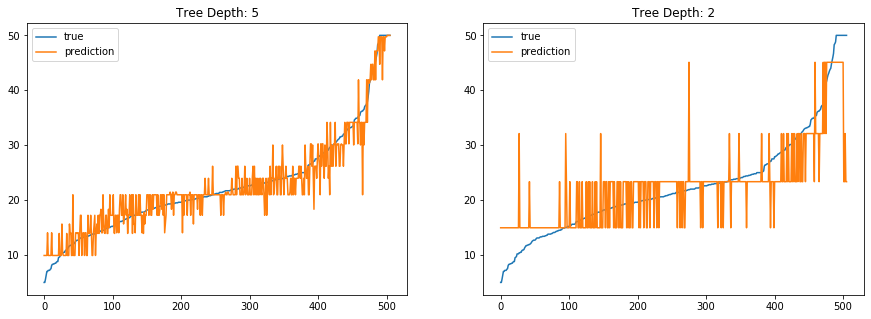

In [36]:
import matplotlib.pyplot as plt

# x 坐标轴
x = list(range(len(y_pred)))

# y 进行排序后的索引值
indexes = sorted(x, key=lambda idx: y[idx])

# y 进行排序，y_pred 对应索引
y = y[indexes]
y_pred_5 = y_pred_5[indexes]
y_pred_2 = y_pred_2[indexes]

# 画图
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, y, label="true")
ax[0].plot(x, y_pred_5, label="prediction")
ax[0].legend()
ax[0].set_title("Tree Depth: 5")

ax[1].plot(x, y, label="true")
ax[1].plot(x, y_pred_2, label="prediction")
ax[1].legend()
ax[1].set_title("Tree Depth: 2")

# 随机森林

In [40]:
from sklearn.datasets import load_iris
iris = load_iris()
print(iris.data.shape, iris.target_names)
# 150 个样本，4 个特征， 3 分类

from sklearn.ensemble import RandomForestClassifier

# n_estimators = 10 ,10 棵树做集成
model = RandomForestClassifier(n_estimators=10)
model.fit(iris.data, iris.target)

# 第 6 棵树
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz

# 可视化第 6 棵树的决策过程
export_graphviz(estimator,
                out_file='tree.dot',
                feature_names=iris.feature_names,
                class_names=iris.target_names,
                rounded=True,
                proportion=False)

(150, 4) ['setosa' 'versicolor' 'virginica']


In [38]:
# 执行系统命令，转化图片
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [39]:
from IPython.display import Image
Image(filename='tree.png')